In [28]:
pip install datasets

In [29]:
pip install chardet

In [30]:
# Import necessary libraries
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import os

In [31]:
# Load tokenizer and pre-trained model
tokenizer = AutoTokenizer.from_pretrained("lakshyakh93/deberta_finetuned_pii")
model = AutoModelForTokenClassification.from_pretrained("lakshyakh93/deberta_finetuned_pii")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [32]:
# # Load the mini dataset (200 row)
# import chardet

# filepath = os.path.join(os.getcwd(), 'mini_df_200_row_biolabels.csv')

# # Detect encoding
# with open(filepath, 'rb') as f:
#     result = chardet.detect(f.read())
#     print("Detected file encoding:", result['encoding'])

# # Read the file using the detected encoding
# mini_df = pd.read_csv(filepath, encoding=result['encoding'])

# # Proportional split ratios
# train_ratio = 0.7
# val_ratio = 0.15
# test_ratio = 0.15

# # Since you have 200 rows, no need for the 3,000 cap, as this won't be needed
# train_size = int(len(mini_df) * train_ratio)
# val_size = int(len(mini_df) * val_ratio)
# test_size = len(mini_df) - train_size - val_size  # Remaining rows for the test set

# # Split the dataset into train, validation, and test sets
# train_df, temp_df = train_test_split(mini_df, test_size=1 - train_ratio, random_state=42)
# val_df, test_df = train_test_split(temp_df, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

# # Print dataset sizes to confirm
# print(f"Training size: {len(train_df)}")
# print(f"Validation size: {len(val_df)}")
# print(f"Test size: {len(test_df)}")

In [33]:
# # For the cleaned mini dataframe
# # Create a mapping for the bio_labels
# data_label_list = []

# # Extract unique labels from the 'bio_labels' column
# def get_unique_labels(df):
#     unique_labels = set()
#     for labels in df['bio_labels']:  # Iterate through the 'bio_labels' column
#         # Since bio_labels is a string representation of a list, we need to convert it back to a list
#         labels = eval(labels)  # Convert the string to a list
#         unique_labels.update(labels)  # Add all labels in the current row to the set
#     return sorted(unique_labels)  # Return sorted labels for consistency

# # Apply the function to the entire DataFrame
# unique_labels = get_unique_labels(mini_df)  # Run on the whole DataFrame

# # Print the unique labels
# print("Data's Unique BIO Labels:", unique_labels)

# # Combine with the existing label_list (if applicable)
# data_label_list = sorted(set(data_label_list + unique_labels))  # Ensure no duplicates
# print("Data's Final Label List:", data_label_list)
# print(len(data_label_list))  # Number of unique labels

# data_label_to_id = {label: idx for idx, label in enumerate(data_label_list)}
# data_id_to_label = {idx: label for label, idx in data_label_to_id.items()}

In [34]:
# Calculate the proportional sizes
total_samples = 15000
train_ratio = 7
val_ratio = 1.5
test_ratio = 1.5

total_ratio = train_ratio + val_ratio + test_ratio

train_size = int(total_samples * (train_ratio / total_ratio))
val_size = int(total_samples * (val_ratio / total_ratio))
test_size = total_samples - train_size - val_size

# Load dataset
dataset = load_dataset("Isotonic/pii-masking-200k")

# First, split off the test and validation sets
first_split = dataset["train"].train_test_split(test_size=(val_size + test_size)/len(dataset["train"]), seed=42)

# Then split the remaining data into train
train_split = first_split["train"].shuffle(seed=42).select(range(train_size))
val_test_split = first_split["test"].shuffle(seed=42).select(range(val_size + test_size))
val_split = val_test_split.select(range(val_size))
test_split = val_test_split.select(range(val_size, val_size + test_size))

# Create the final DatasetDict
dataset_splits = DatasetDict({
    "train": train_split,
    "validation": val_split,
    "test": test_split
})

print(f"Training size: {len(dataset_splits['train'])}")
print(f"Validation size: {len(dataset_splits['validation'])}")
print(f"Test size: {len(dataset_splits['test'])}")

Training size: 10500
Validation size: 2250
Test size: 2250


In [35]:
# Convert test_dataset into a dataframe
pii200k_train = dataset_splits['train'].to_pandas()
pii200k_val = dataset_splits['test'].to_pandas()
pii200k_test = dataset_splits['test'].to_pandas()

eng_train = pii200k_train[pii200k_train['language'] == 'en']
eng_val = pii200k_val[pii200k_val['language'] == 'en']
eng_test = pii200k_test[pii200k_test['language'] == 'en']

print(len(eng_train))
print(len(eng_val))
print(len(eng_test))

2120
478
478


In [36]:
# Filter rows where 'bio_labels' is not null (though unlikely given your data)
valid_eng_train = eng_train[eng_train['bio_labels'].notnull()]
valid_eng_val = eng_val[eng_val['bio_labels'].notnull()]
valid_eng_test = eng_test[eng_test['bio_labels'].notnull()]

import numpy as np
import re

def clean_bio_labels(bio_labels):
    # Flatten the numpy array of bio_labels and remove any non-printable characters
    bio_labels = [label for label in bio_labels.flatten() if isinstance(label, str)]
    cleaned_labels = [re.sub(r'[^\x20-\x7E]', '', label) for label in bio_labels]
    return cleaned_labels

# Apply the cleaning function to each bio_labels entry
eng_train['bio_labels'] = eng_train['bio_labels'].apply(clean_bio_labels)
eng_val['bio_labels'] = eng_val['bio_labels'].apply(clean_bio_labels)
eng_test['bio_labels'] = eng_test['bio_labels'].apply(clean_bio_labels)

# Check the resulting DataFrame
print(f"Number of valid rows in eng_train: {len(eng_train)}")
print(f"Number of valid rows in eng_val: {len(eng_val)}")
print(f"Number of valid rows in eng_test: {len(eng_test)}")

Number of valid rows in eng_train: 2120
Number of valid rows in eng_val: 478
Number of valid rows in eng_test: 478


<ipython-input-36-a54fa4498df2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_train['bio_labels'] = eng_train['bio_labels'].apply(clean_bio_labels)
<ipython-input-36-a54fa4498df2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_val['bio_labels'] = eng_val['bio_labels'].apply(clean_bio_labels)
<ipython-input-36-a54fa4498df2>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [37]:
data_label_list = []

# Extract unique BIO labels
unique_labels = set()

# Iterate through the 'bio_labels' column
for labels in eng_train['bio_labels']:
    unique_labels.update(labels)  # Add all unique labels from each array

# Convert to sorted list for consistency
unique_labels = sorted(unique_labels)

print("Data's Unique BIO Labels:", unique_labels)
print(f"Number of unique labels: {len(unique_labels)}")

# Combine with the existing label_list (if applicable)
data_label_list = sorted(set(data_label_list + unique_labels))  # Ensure no duplicates
print("Data's Final Label List:", data_label_list)
print(len(data_label_list))  # Number of unique labels

data_label_to_id = {label: idx for idx, label in enumerate(data_label_list)}
data_id_to_label = {idx: label for label, idx in data_label_to_id.items()}

Data's Unique BIO Labels: ['B-ACCOUNTNAME', 'B-ACCOUNTNUMBER', 'B-AGE', 'B-AMOUNT', 'B-BIC', 'B-BITCOINADDRESS', 'B-BUILDINGNUMBER', 'B-CITY', 'B-COMPANYNAME', 'B-COUNTY', 'B-CREDITCARDCVV', 'B-CREDITCARDISSUER', 'B-CREDITCARDNUMBER', 'B-CURRENCY', 'B-CURRENCYCODE', 'B-CURRENCYNAME', 'B-CURRENCYSYMBOL', 'B-DATE', 'B-DOB', 'B-EMAIL', 'B-ETHEREUMADDRESS', 'B-EYECOLOR', 'B-FIRSTNAME', 'B-GENDER', 'B-HEIGHT', 'B-IBAN', 'B-IP', 'B-IPV4', 'B-IPV6', 'B-JOBAREA', 'B-JOBTITLE', 'B-JOBTYPE', 'B-LASTNAME', 'B-LITECOINADDRESS', 'B-MAC', 'B-MASKEDNUMBER', 'B-MIDDLENAME', 'B-NEARBYGPSCOORDINATE', 'B-ORDINALDIRECTION', 'B-PASSWORD', 'B-PHONEIMEI', 'B-PHONENUMBER', 'B-PIN', 'B-PREFIX', 'B-SECONDARYADDRESS', 'B-SEX', 'B-SSN', 'B-STATE', 'B-STREET', 'B-TIME', 'B-URL', 'B-USERAGENT', 'B-USERNAME', 'B-VEHICLEVIN', 'B-VEHICLEVRM', 'B-ZIPCODE', 'I-ACCOUNTNAME', 'I-ACCOUNTNUMBER', 'I-AGE', 'I-AMOUNT', 'I-BIC', 'I-BITCOINADDRESS', 'I-BUILDINGNUMBER', 'I-CITY', 'I-COMPANYNAME', 'I-COUNTY', 'I-CREDITCARDCVV', '

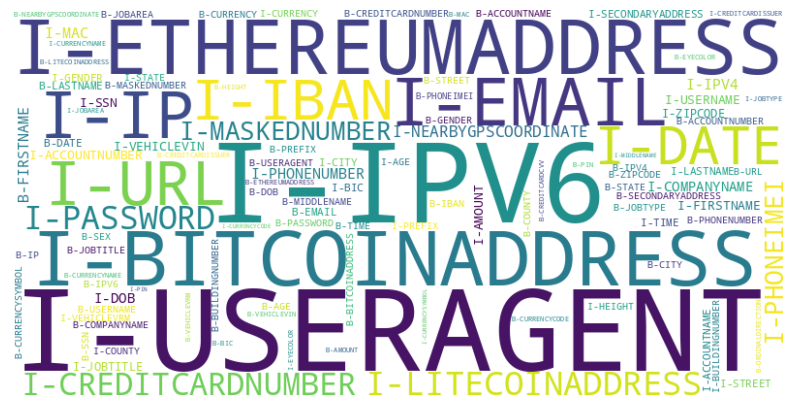

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming sorted_labels is a list of tuples [(label, count), ...]
# Remove the "O" label from the sorted labels
filtered_labels = [(label, freq) for label, freq in sorted_labels if label != "O"]

# Create a dictionary of word frequencies excluding "O"
word_freq = {label: freq for label, freq in filtered_labels}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis_r").generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [39]:
model_label_list = model.config.id2label.values()  # Ensure this matches the fine-tuned model
model_id_to_label = {int(k): v for k, v in model.config.id2label.items()}
model_label_to_id = {v: int(k) for k, v in model_id_to_label.items()}

print("Model's Label to ID:", model_label_to_id)
print("Model's ID to Label:", model_id_to_label)
print(len(model_label_list))

Model's Label to ID: {'B-PREFIX': 0, 'I-PREFIX': 1, 'B-FIRSTNAME': 2, 'I-FIRSTNAME': 3, 'B-MIDDLENAME': 4, 'B-LASTNAME': 5, 'I-LASTNAME': 6, 'O': 7, 'B-JOBDESCRIPTOR': 8, 'B-JOBTITLE': 9, 'I-JOBTITLE': 10, 'B-COMPANY_NAME': 11, 'I-COMPANY_NAME': 12, 'B-JOBAREA': 13, 'B-EMAIL': 14, 'I-EMAIL': 15, 'B-TIME': 16, 'I-TIME': 17, 'B-DATE': 18, 'I-DATE': 19, 'B-URL': 20, 'I-URL': 21, 'B-BITCOINADDRESS': 22, 'I-BITCOINADDRESS': 23, 'B-ETHEREUMADDRESS': 24, 'I-ETHEREUMADDRESS': 25, 'B-ACCOUNTNAME': 26, 'I-ACCOUNTNAME': 27, 'B-IBAN': 28, 'I-IBAN': 29, 'B-ACCOUNTNUMBER': 30, 'I-ACCOUNTNUMBER': 31, 'B-BIC': 32, 'I-BIC': 33, 'B-IPV4': 34, 'I-IPV4': 35, 'B-STREETADDRESS': 36, 'I-STREETADDRESS': 37, 'B-CITY': 38, 'I-CITY': 39, 'B-ZIPCODE': 40, 'I-ZIPCODE': 41, 'B-USERNAME': 42, 'I-USERNAME': 43, 'B-IPV6': 44, 'I-IPV6': 45, 'B-CREDITCARDNUMBER': 46, 'I-CREDITCARDNUMBER': 47, 'B-VEHICLEVIN': 48, 'I-VEHICLEVIN': 49, 'B-SUFFIX': 50, 'I-SUFFIX': 51, 'B-AMOUNT': 52, 'I-AMOUNT': 53, 'B-CURRENCY': 54, 'I-CURR

In [40]:
# Define metrics calculation function
def compute_metrics(predictions, references):
    acc = accuracy_score(references, predictions)
    precision = precision_score(references, predictions, average="weighted", zero_division=1)
    recall = recall_score(references, predictions, average="weighted", zero_division=1)
    f1 = f1_score(references, predictions, average="weighted", zero_division=1)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [41]:
from transformers import DataCollatorForTokenClassification
from torch.utils.data import DataLoader
import numpy as np

def tokenize_and_align_labels(df, tokenizer, data_label_to_id, model_label_to_id):
    def normalize_label(label):
        # Remove suffixes like "_1", "_2"
        if "_" in label and label.split("_")[-1].isdigit():
            return "_".join(label.split("_")[:-1])
        return label

    def map_labels_to_model(data_label):
        normalized_label = normalize_label(data_label)  # Normalize dataset labels
        return model_label_to_id.get(normalized_label, model_label_to_id.get("O", -100))  # Default to "O"

    # Tokenize input text
    tokenized_inputs = tokenizer(
        list(df["unmasked_text"]),  # Convert Series to list of strings
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt",
        is_split_into_words=False,
    )

    labels = []
    for i, label_seq in enumerate(df["bio_labels"]):
        word_labels = eval(label_seq) if isinstance(label_seq, str) else label_seq  # Convert string back to list if needed
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens back to words
        token_labels = []
        for word_id in word_ids:
            if word_id is None:  # Special tokens
                token_labels.append(-100)
            elif word_id < len(word_labels):  # Ensure within bounds
                token_labels.append(map_labels_to_model(word_labels[word_id]))
            else:
                token_labels.append(-100)  # Ignore out-of-bounds tokens
        labels.append(token_labels)

    tokenized_inputs["labels"] = torch.tensor(labels)
    return tokenized_inputs

# Tokenize the training set
tokenized_train = tokenize_and_align_labels(eng_train, tokenizer, data_label_to_id, model_label_to_id)
# Create a DataLoader for the training set
train_dataset = torch.utils.data.TensorDataset(tokenized_train["input_ids"], tokenized_train["attention_mask"], tokenized_train["labels"])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Tokenize the validation set
tokenized_val = tokenize_and_align_labels(eng_val, tokenizer, data_label_to_id, model_label_to_id)
# Create a DataLoader for the validation set
val_dataset = torch.utils.data.TensorDataset(tokenized_val["input_ids"], tokenized_val["attention_mask"], tokenized_val["labels"])
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Tokenize the test set
tokenized_test = tokenize_and_align_labels(eng_test, tokenizer, data_label_to_id, model_label_to_id)
# Create a DataLoader for the test set
test_dataset = torch.utils.data.TensorDataset(tokenized_test["input_ids"], tokenized_test["attention_mask"], tokenized_test["labels"])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
for key, value in tokenized_train.items():
    print(f"{key}: {value.shape}")

for key, value in tokenized_val.items():
    print(f"{key}: {value.shape}")

for key, value in tokenized_test.items():
    print(f"{key}: {value.shape}")

input_ids: torch.Size([2120, 140])
token_type_ids: torch.Size([2120, 140])
attention_mask: torch.Size([2120, 140])
labels: torch.Size([2120, 140])
input_ids: torch.Size([478, 137])
token_type_ids: torch.Size([478, 137])
attention_mask: torch.Size([478, 137])
labels: torch.Size([478, 137])
input_ids: torch.Size([478, 137])
token_type_ids: torch.Size([478, 137])
attention_mask: torch.Size([478, 137])
labels: torch.Size([478, 137])


In [43]:
id_to_label = {v: k for k, v in model_label_to_id.items()}

In [44]:
# # Find the optimized hyperparameters

# import optuna

# def objective(trial):
#     # Suggest hyperparameters
#     batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
#     temperature = trial.suggest_float("temperature", 0.5, 2.0)
#     use_fp16 = trial.suggest_categorical("use_fp16", [True, False])

#     # Configure inference settings
#     all_predictions, all_references = [], []
#     model.eval()

#     with torch.no_grad():
#         for batch in test_dataloader:
#             input_ids, attention_mask, labels = [t.to(device) for t in batch]

#             # Mixed precision inference
#             with torch.cuda.amp.autocast(enabled=use_fp16):
#                 outputs = model(input_ids, attention_mask=attention_mask)
#                 logits = outputs.logits / temperature  # Apply temperature scaling

#             # Get predictions
#             predictions = torch.argmax(logits, dim=-1).cpu().numpy()
#             labels = labels.cpu().numpy()

#             # Align predictions and references to only include non-special tokens
#             for pred, label in zip(predictions, labels):
#                 true_labels = [id_to_label[l] for l in label if l != -100]
#                 pred_labels = [
#                     id_to_label.get(p, "O") for p, l in zip(pred, label) if l != -100
#                 ]
#                 all_predictions.extend(pred_labels)
#                 all_references.extend(true_labels)

#     # Calculate metrics
#     metrics = compute_metrics(all_predictions, all_references)
#     return metrics["f1"]  # Optimize for F1 score

# # Hyperparameter optimization with Optuna
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)

# # Display the best hyperparameters
# print("Best hyperparameters:", study.best_params)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from torch.optim import AdamW
from transformers import get_scheduler
from torch.cuda.amp import GradScaler, autocast

# Initialize lists to store loss and metrics
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_val_metric = float('-inf')  # Initialize best metric as negative infinity
epochs_without_improvement = 0  # Counter for no improvement

# Initialize GradScaler for mixed precision
scaler = GradScaler()

# Define optimizer and scheduler
optimizer = AdamW([
    {"params": model.deberta.encoder.layer[:6].parameters(), "lr": 1e-5},  # Lower LR for bottom layers
    {"params": model.deberta.encoder.layer[6:].parameters(), "lr": 2e-5},  # Higher LR for top layers
    {"params": model.classifier.parameters(), "lr": 2e-5},  # Classifier head
])
num_epochs = 10
num_training_steps = len(train_dataloader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_training_steps)

# Freezing the first 6 layers of the encoder
for name, param in model.named_parameters():
    # Check if the parameter belongs to the encoder's layers
    if "deberta.encoder.layer" in name:
        try:
            layer_num = int(name.split(".")[3])  # Extract layer number
            if layer_num < 6:  # Freeze the first 6 layers
                param.requires_grad = False
        except ValueError:
            # Ignore parameters that don't follow the expected format
            continue
    else:
        # Leave other parameters trainable (e.g., classifier)
        param.requires_grad = True

# Check which layers are trainable
trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]
print(f"Trainable parameters: {trainable_params}")

# Training and validation loop
model.train()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    total_loss = 0
    step = 0

    # Training loop
    for batch in train_dataloader:
        input_ids, attention_mask, labels = [t.to(device) for t in batch]

        with autocast():  # Updated autocast usage
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        lr_scheduler.step()

        if step % 10 == 0:  # Log every 10 steps
            avg_loss = total_loss / (step + 1)
            print(f"Step {step}/{len(train_dataloader)}, Loss: {loss.item()}, Avg Loss: {avg_loss}")

        step += 1

    # Calculate average training loss
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} Training Loss: {avg_train_loss}")

    # Validation loop
    model.eval()
    val_loss = 0
    all_predictions, all_references = [], []
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]
            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
            labels = labels.cpu().numpy()

            # Process predictions and references
            for pred, label in zip(predictions, labels):
                true_labels = [id_to_label[l] for l in label if l != -100]
                pred_labels = [id_to_label.get(p, "O") for p, l in zip(pred, label) if l != -100]
                all_predictions.extend(pred_labels)
                all_references.extend(true_labels)

    # Compute validation metrics
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    metrics = compute_metrics(all_predictions, all_references)
    print(f"Validation Metrics: {metrics}")
    val_accuracies.append(metrics['accuracy'])
    val_precisions.append(metrics['precision'])
    val_recalls.append(metrics['recall'])
    val_f1_scores.append(metrics['f1'])

    print(f"Validation Metrics: {metrics}")
    print(f"Epoch {epoch + 1} Validation Loss: {avg_val_loss}")
    # Early stopping logic
    val_metric = metrics['f1']  # Use F1 score as the metric to monitor
    if val_metric > best_val_metric:
        best_val_metric = val_metric
        epochs_without_improvement = 0
        print("Validation F1 improved. Saving model...")
        torch.save(model.state_dict(), "best_deberta.pth")  # Save best model
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s).")

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        break

    model.train()  # Return to training mode

Trainable parameters: ['deberta.embeddings.word_embeddings.weight', 'deberta.embeddings.LayerNorm.weight', 'deberta.embeddings.LayerNorm.bias', 'deberta.encoder.layer.6.attention.self.q_bias', 'deberta.encoder.layer.6.attention.self.v_bias', 'deberta.encoder.layer.6.attention.self.in_proj.weight', 'deberta.encoder.layer.6.attention.self.pos_proj.weight', 'deberta.encoder.layer.6.attention.self.pos_q_proj.weight', 'deberta.encoder.layer.6.attention.self.pos_q_proj.bias', 'deberta.encoder.layer.6.attention.output.dense.weight', 'deberta.encoder.layer.6.attention.output.dense.bias', 'deberta.encoder.layer.6.attention.output.LayerNorm.weight', 'deberta.encoder.layer.6.attention.output.LayerNorm.bias', 'deberta.encoder.layer.6.intermediate.dense.weight', 'deberta.encoder.layer.6.intermediate.dense.bias', 'deberta.encoder.layer.6.output.dense.weight', 'deberta.encoder.layer.6.output.dense.bias', 'deberta.encoder.layer.6.output.LayerNorm.weight', 'deberta.encoder.layer.6.output.LayerNorm.bias

<ipython-input-45-eac591985c4f>:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-45-eac591985c4f>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/67, Loss: 4.759023666381836, Avg Loss: 4.759023666381836
Step 10/67, Loss: 2.7888519763946533, Avg Loss: 3.342505931854248
Step 20/67, Loss: 1.8832013607025146, Avg Loss: 2.805244729632423
Step 30/67, Loss: 1.2278966903686523, Avg Loss: 2.4328500147788756
Step 40/67, Loss: 1.3991962671279907, Avg Loss: 2.159273452875091
Step 50/67, Loss: 0.9946317076683044, Avg Loss: 1.9635158040944267
Step 60/67, Loss: 1.0034027099609375, Avg Loss: 1.8111531499956475
Epoch 1 Training Loss: 1.7348380720437462


<ipython-input-45-eac591985c4f>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.7347015805614532, 'precision': 0.7151913378426218, 'recall': 0.7347015805614532, 'f1': 0.7056598420076373}
Validation Metrics: {'accuracy': 0.7347015805614532, 'precision': 0.7151913378426218, 'recall': 0.7347015805614532, 'f1': 0.7056598420076373}
Epoch 1 Validation Loss: 0.996014122168223
Validation F1 improved. Saving model...

Epoch 2/10


<ipython-input-45-eac591985c4f>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/67, Loss: 1.082013726234436, Avg Loss: 1.082013726234436
Step 10/67, Loss: 0.9384075999259949, Avg Loss: 0.9660899422385476
Step 20/67, Loss: 0.7248204946517944, Avg Loss: 0.9254122972488403
Step 30/67, Loss: 0.7227241396903992, Avg Loss: 0.9117085030001979
Step 40/67, Loss: 0.917587399482727, Avg Loss: 0.8929013391820396
Step 50/67, Loss: 0.7169082164764404, Avg Loss: 0.8678391038202772
Step 60/67, Loss: 0.7614877820014954, Avg Loss: 0.8472980241306493
Epoch 2 Training Loss: 0.8352047854395055


<ipython-input-45-eac591985c4f>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.7645199339466855, 'precision': 0.7533318802600987, 'recall': 0.7645199339466855, 'f1': 0.7470810623518992}
Validation Metrics: {'accuracy': 0.7645199339466855, 'precision': 0.7533318802600987, 'recall': 0.7645199339466855, 'f1': 0.7470810623518992}
Epoch 2 Validation Loss: 0.7819263299306234
Validation F1 improved. Saving model...

Epoch 3/10


<ipython-input-45-eac591985c4f>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/67, Loss: 0.8640230894088745, Avg Loss: 0.8640230894088745
Step 10/67, Loss: 0.7120344638824463, Avg Loss: 0.7346460277383978
Step 20/67, Loss: 0.5710815787315369, Avg Loss: 0.7210790543329149
Step 30/67, Loss: 0.633014976978302, Avg Loss: 0.7182752663089383
Step 40/67, Loss: 0.7979484796524048, Avg Loss: 0.7152699842685606
Step 50/67, Loss: 0.6439769864082336, Avg Loss: 0.7016423800412346
Step 60/67, Loss: 0.680200457572937, Avg Loss: 0.691953962943593
Epoch 3 Training Loss: 0.6840654736134544


<ipython-input-45-eac591985c4f>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Metrics: {'accuracy': 0.77655107336636, 'precision': 0.759895717814571, 'recall': 0.77655107336636, 'f1': 0.7587383429458351}
Validation Metrics: {'accuracy': 0.77655107336636, 'precision': 0.759895717814571, 'recall': 0.77655107336636, 'f1': 0.7587383429458351}
Epoch 3 Validation Loss: 0.7014434615770976
Validation F1 improved. Saving model...

Epoch 4/10


<ipython-input-45-eac591985c4f>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated autocast usage


Step 0/67, Loss: 0.7534191608428955, Avg Loss: 0.7534191608428955
Step 10/67, Loss: 0.6192367672920227, Avg Loss: 0.6502055688337847
Step 20/67, Loss: 0.49624142050743103, Avg Loss: 0.6413284838199615
Step 30/67, Loss: 0.5778599977493286, Avg Loss: 0.644639887156025
Step 40/67, Loss: 0.7209165096282959, Avg Loss: 0.6432840976773239
Step 50/67, Loss: 0.6216241121292114, Avg Loss: 0.6352834520386714


In [ ]:
from google.colab import files

# Download the saved model file
files.download("best_deberta.pth")

In [ ]:
# Visualization
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot validation metrics
plt.figure(figsize=(12, 10))
plt.plot(epochs, val_accuracies, label="Accuracy")
plt.plot(epochs, val_precisions, label="Precision")
plt.plot(epochs, val_recalls, label="Recall")
plt.plot(epochs, val_f1_scores, label="F1 Score")
plt.title("Validation Metrics")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.show()

In [ ]:
# Inference loop using the optimized hyperparameters
all_predictions, all_references = [], []
model.load_state_dict(torch.load("best_deberta.pth"))
model.to(device)

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [t.to(device) for t in batch]

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits / 0.9989592666538125  # Use optimized temperature

        # Get predictions
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        labels = labels.cpu().numpy()

        # Align predictions and references to only include non-special tokens
        for pred, label in zip(predictions, labels):
            true_labels = [
                id_to_label[l] for l in label if l != -100
            ]  # Convert ground truth IDs to labels
            pred_labels = [
                id_to_label.get(p, "O") for p, l in zip(pred, label) if l != -100
            ]  # Convert predictions to labels, defaulting to "O" for unmapped IDs

            all_predictions.extend(pred_labels)
            all_references.extend(true_labels)

# Calculate metrics
metrics = compute_metrics(all_predictions, all_references)
print("Test metrics:", metrics)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize your true and predicted labels (use label_binarize for multilabel)
true_binary = label_binarize(all_references, classes=list(id_to_label.values()))
pred_binary = label_binarize(all_predictions, classes=list(id_to_label.values()))

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(true_binary.ravel(), pred_binary.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Extract the unique classes from all_references and all_predictions
unique_labels = sorted(set(all_references) | set(all_predictions))
display_labels = [id_to_label[label] for label in unique_labels]

# Plot the confusion matrix with consistent labels
ConfusionMatrixDisplay.from_predictions(
    all_references,
    all_predictions,
    display_labels=display_labels
)
plt.title("Confusion Matrix (Filtered Labels)")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(all_references, all_predictions, output_dict=True)
df = pd.DataFrame(report).transpose()

# Plot F1 scores for each label
df["f1-score"].plot(kind="bar", figsize=(12, 6))
plt.title("F1 Score by Label")
plt.ylabel("F1 Score")
plt.xlabel("Labels")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import numpy as np

cm = confusion_matrix(all_references, all_predictions)
misclassified_indices = np.unravel_index(np.argsort(-cm, axis=None), cm.shape)
top_misclassifications = [
    (id_to_label[misclassified_indices[0][i]], id_to_label[misclassified_indices[1][i]], cm[misclassified_indices[0][i], misclassified_indices[1][i]])
    for i in range(10)  # Top 10 misclassifications
]

for true, predicted, count in top_misclassifications:
    print(f"True: {true}, Predicted: {predicted}, Count: {count}")

# Extract unique indices for the top misclassifications
unique_indices = list(set([misclassified_indices[0][i] for i in range(10)] +
                          [misclassified_indices[1][i] for i in range(10)]))

# Create a subset confusion matrix
subset_cm = cm[np.ix_(unique_indices, unique_indices)]
subset_labels = [list(id_to_label.values())[i] for i in unique_indices]

# Plot the subset confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=subset_cm, display_labels=subset_labels)
disp.plot(cmap="viridis", xticks_rotation="vertical", colorbar=True)
plt.title("Confusion Matrix For Top Misclassifications)")
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Convert string labels to numeric IDs using id_to_label reverse mapping
label_to_id_reverse = {label: idx for idx, label in id_to_label.items()}

# Map predictions and references to numeric IDs
numeric_predictions = [label_to_id_reverse[label] for label in all_predictions]
numeric_references = [label_to_id_reverse[label] for label in all_references]

# Choose the label ID of interest (e.g., for binary classification, the positive class)
pos_label_id = label_to_id_reverse["B-CREDITCARDNUMBER"]  # Replace "B-YOUR_LABEL" with your target class

# Compute precision-recall curve
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, _ = precision_recall_curve(numeric_references, numeric_predictions, pos_label=pos_label_id)

# Plot the Precision-Recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()

# Flatten predictions and references for multiclass handling (if applicable)
# Note: This works best for binary or one-vs-all analysis.
# Example below assumes binary or flattened labels.
precision, recall, _ = precision_recall_curve(numeric_references, numeric_predictions, pos_label="B-CREDITCARDNUMBER")

# Display Precision-Recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()
